**The Employment of Text Analytics in Pacific Islands Countries -- the Example of Solomon Islands**

## Economic Policy Uncertainty

 - Baker, Bloom, and Davis (2016) published an article on QJE, named "[Measuring Economic Policy Uncertainty](https://doi.org/10.1093/qje/qjw024)", which has been cited more than 9800 times on Google Scholar.
 - They found that "innovations in policy uncertainty foreshadow declines in investment, output, and employment in the United States and, in a panel vector autoregressive setting, for 12 major economies."
 - They also created category-specific EPU indexes, like health-care, trade policy, national security, entitlement program, etc.

**Example: Solomon Islands**
- We used four major newspapers in Solomon Islands, all of which can be accessible (scraped) via internet:
    - ***Solomon Stars*** has been available from 2014-04;
    - ***Solomon Times*** has been available from 2007-04;
    - ***The Island Sun*** has been available from 2017-08; and
    - ***Solomon Islands Broadcasting Corporation*** has been available from 2014-12;

**How to calculate the EPU index**

- Define three buckets of words;
    - **Economic**: economy/economic/economics/business/commerce/finance/financial/industry
    - **Policy**:  government/governmental/authorities/minister/ministry/parliament/parliamentary/tax/regulation/legislation/central bank/cbsi/imf/world bank/international monetary fund/debt"
    - **Uncertainty**: uncertain/uncertainty/uncertainties/unknown/unstable/unsure/undetermined/risk/risky/not certain/non-reliable
- Find the scaled count of EPU news ($X_{it} = \frac{EPU news}{All news}$) for newspaper $i$ for time $t$;
- Get the standard deviation $\sigma_i$ for each newspaper $i$;
- Standardize $X_{it}$ by dividing $\sigma_i$ for all time $t$, giving a $Y_{it}$;
- Compute the mean over newspapers of $Y_{it}$ in each month to obtain the series $Z_t$;
- Compute $M$, the mean value of $Z_t$;
- Multiply $Z_t$ by (100/$M$) for all t to obtain the normalized EPU time-series index;


In [1]:
import os
os.chdir("../../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import  HTML, display


folderpath = os.getcwd() + "/data/text/solomon_islands/"
ldavis_path = folderpath + "st_ldavis.html"

def process_data(filename, folderpath=folderpath):
    df = pd.read_csv(folderpath + filename).drop("Unnamed: 0", axis=1)
    df["news"] = df["news"].str.lower()
    df["date"] = pd.to_datetime(df["date"])
    df["ym"] = [str(d.year) + "-" + str(d.month) for d in df.date]
    return df

def get_news_count(data: pd.DataFrame, column: str):
    count_df = (data.set_index("date")
                .groupby("ym")[[str(column)]]
                .count()
                .reset_index()
                .rename({str(column): str(column) + "_count"}, axis=1))
    return count_df

def check_epu_category(row, terms):
    return any([word in str(row) for word in terms])

def get_epu_zscore(data: pd.DataFrame) -> pd.Series:
    ratio = data["epu_count"] / data["news_count"]
    mean, std = ratio.mean(), ratio.std()
    z_score = abs(ratio - mean) / std
    return z_score

ss = process_data("solomon_stars_news.csv")
st = process_data("solomon_times_news.csv")
tis = process_data("island_sun_news.csv")
sibc = process_data("sibc_news.csv")

mindate = min(st.date.min(), ss.date.min(), tis.date.min())
maxdate = max(st.date.max(), st.date.max(),  tis.date.max())
start = str(mindate.year) + "-" + str(mindate.month)
end = str(maxdate.year) + "-" + str(maxdate.month)

econ_lst = [
    "economy", "economic", "economics", "business", "commerce", "finance",
    "financial", "industry"
]

uncertain_lst = [
    "uncertain", "uncertainty", "uncertainties", "unknown", "unstable",
    "unsure", "undetermined", "risk", "risky", "not certain", "non-reliable"
]

policy_lst = [
    "government", "governmental", "authorities", "minister", "ministry",
    "parliament", "parliamentary", "tax", "regulation", "legislation",
    "central bank", "cbsi", "imf", "world bank", "international monetary fund",
    "debt"
]

stats = pd.DataFrame(pd.date_range(start, end, freq="MS"), columns=["date"])
for np, np_name in zip([st, ss, tis, sibc], ["st", "ss", "tis", "sibc"]):
    np_count = get_news_count(np, "news")
    for (category, term_lst) in zip(["econ", "uncertain", "policy"],
                                    [econ_lst, uncertain_lst, policy_lst]):
        np[str(category)] = np["news"].apply(check_epu_category,
                                             terms=term_lst)
    np["epu"] = (np.econ == True) & (np.uncertain == True) & (np.policy
                                                              == True)
    np_epu_count = get_news_count(np[np.epu == True], column="epu")
    np_stat = np_count.merge(np_epu_count, how="left").fillna(0)
    np_stat["date"] = pd.to_datetime(np_stat["ym"])
    np_stat["z_score"] = get_epu_zscore(np_stat)
    np_stat.columns = [
        str(np_name) + "_" + str(col) if col != "date" and col != "ym" else col
        for col in np_stat.columns
    ]
    stats = (stats.merge(np_stat, how="left",
                         on="date")).drop("ym", axis=1).fillna(0)
    
stats["z_score"] = (stats["st_z_score"] + stats["ss_z_score"])/2
scale_factor = 100/(stats["z_score"].mean())
stats["epu_index"] = stats["z_score"] * scale_factor

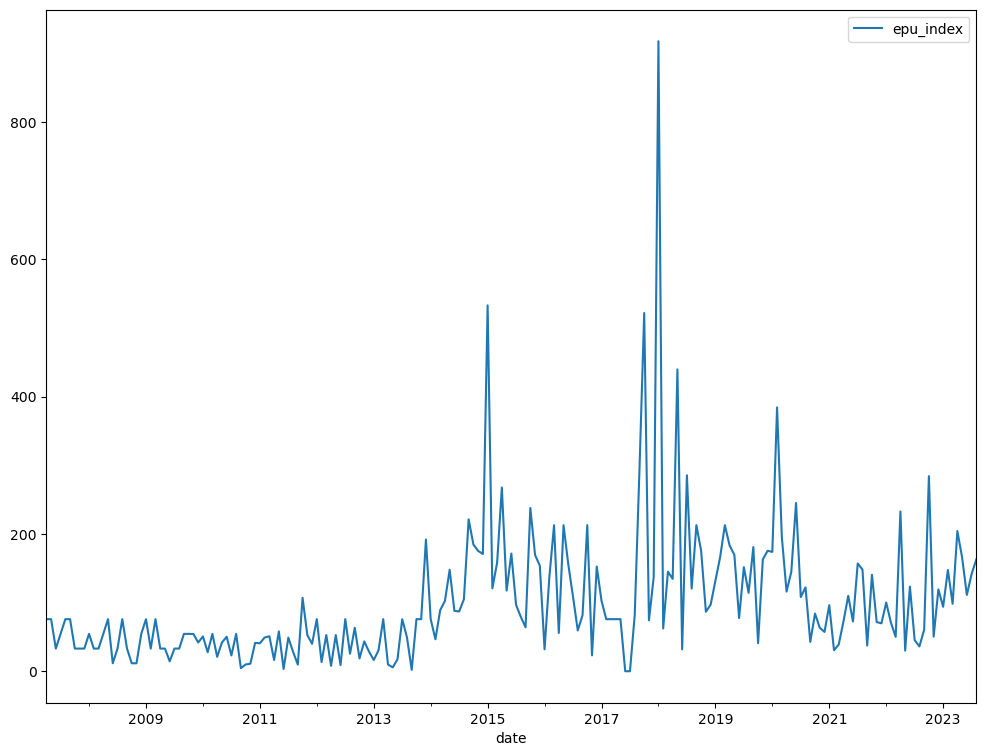

In [2]:
fig, ax = plt.subplots(figsize=(12, 9))
stats.plot(x="date", y="epu_index", ax=ax);

## Topic Modeling

Latent dirichlet allocation (LDA) is a frequently employed methods for topic modeling.
- We trained LDA model on the above-mentioned four solomon islands news papers and select the optimal number of topics based on the evaluation metrics (coherence values).
- We can observe from next page that:
    - Topic 1 is mostly about economic development/policy;
    - Topic 4 is about infrastructure/road, and topic 6 is about opportunity/training;
    - Topic 15 and 18 are about election and police;
    - Topic 17 is about education;

In [3]:
display(HTML(ldavis_path))

## Sentimental Analysis

- Sentiment Analysis is frequently employed in natural language processing;
- In gist, it calculates a score from -1 to +1, reflecting not only the direction but also the intensity of emotions embedded in a corpus.
- Below uses the above-mentioned four newspapers:
    - calculate the sentiment compound score for each news and get a monthly average, $X_{it}$ for each newspaper $i$ at time $t$;
    - Get an average over four newspapers, yielding a time-series sentimen score $S_t$

In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

sid = SentimentIntensityAnalyzer()

date_df = pd.DataFrame(pd.date_range(mindate, maxdate, freq="M"), columns=["date"])
date_df["ym"] = [str(d.year) + '-' + str(d.month) for d in date_df.date]
date_df = date_df.drop("date", axis=1)
for np, np_name in zip([st, ss, tis, sibc], ["st", "ss", "tis", "sibc"]):
    score_df = pd.DataFrame()
    for idx, news in enumerate(np["news"]):
        if type(news) == str:
            scores = sid.polarity_scores(news)
            ss_temp = pd.DataFrame(scores, columns=scores.keys(), index=[idx])
            if score_df.empty:
                score_df = ss_temp
            else:
                score_df = pd.concat([score_df, ss_temp], axis=0)
    sa = pd.concat([np, score_df], axis=1)
    sa_month = sa.groupby("ym")[["compound"]].mean().reset_index().rename({"compound": np_name}, axis=1)
    date_df = date_df.merge(sa_month, how="left", on="ym")

In [5]:
date_df["ym"] = pd.to_datetime(date_df["ym"])
date_df["avg"] = date_df[["st", "ss", "tis", "sibc"]].mean(axis=1)
viz_df = date_df.melt(id_vars="ym").dropna()

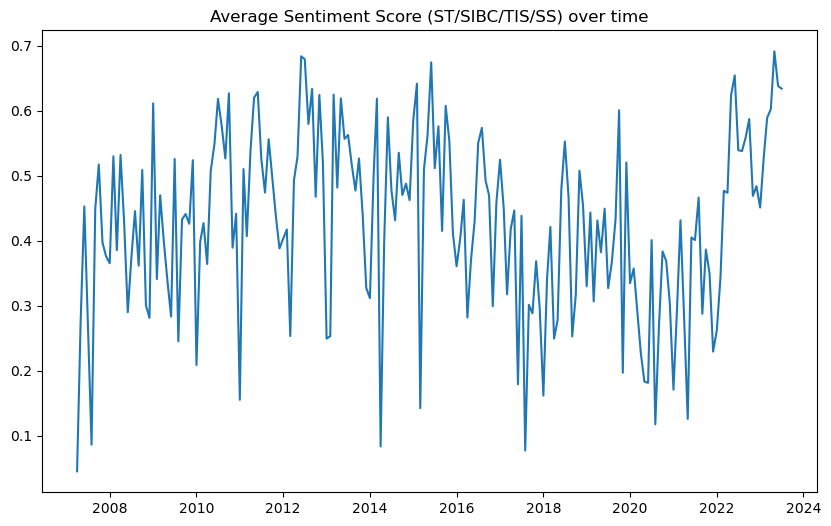

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(date_df["ym"].values, date_df["avg"].values, label="Average")
ax.set_title("Average Sentiment Score (ST/SIBC/TIS/SS) over time")
plt.show()